### LOAD DATA & PREP FOR FMM

In [28]:
import pandas as pd
from sklearn.preprocessing import MultiLabelBinarizer, StandardScaler

# Load splits
df_train = pd.read_csv("../data/cache/poster3_train_graphed.csv")
df_val = pd.read_csv("../data/cache/poster3_val_graphed.csv")
df_test = pd.read_csv("../data/cache/poster3_test.csv")

# Budget column (for labels)
budget_col = "from_budget_category"

# Helper: safely split strings into lists
def split_tags(col):
    return col.fillna("").apply(lambda x: [t.strip() for t in x.split(",") if t.strip()])

# Function to process each split and keep genre/subgenre cols in the final df
def process_split(df):
    # Drop indie budget tier
    df = df[df["from_budget_category"] != "indie"].reset_index(drop=True)

    genres = pd.DataFrame(mlb_genre.transform(split_tags(df["genres"])),
                          columns=[f"genre_{g}" for g in mlb_genre.classes_])
    
    subgenres = pd.DataFrame(mlb_subgenre.transform(split_tags(df["subgenres"])),
                             columns=[f"subgenre_{s}" for s in mlb_subgenre.classes_])
    
    numeric = df[["from_runtimeMinutes"]].reset_index(drop=True)

    # Concatenate all features into X
    X = pd.concat([numeric, genres, subgenres], axis=1)
    y = df["profit"].reset_index(drop=True)

    # Also append the genre/subgenre one-hot columns to the original df
    df = df.reset_index(drop=True)
    df = pd.concat([df, genres, subgenres], axis=1)

    return X, y, df





# Process each split
X_train_raw, y_train, df_train_filtered = process_split(df_train)
X_val_raw, y_val, df_val_filtered = process_split(df_val)
X_test_raw, y_test, df_test_filtered = process_split(df_test)


# Scale all features based on training stats
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train_raw)
X_val = scaler.transform(X_val_raw)
X_test = scaler.transform(X_test_raw)

print("Datasets locked and loaded!")

Datasets locked and loaded!


In [59]:
df_test.columns

Index(['Unnamed: 0', 'from_tconst', 'from_label', 'from_title', 'from_year',
       'from_runtimeMinutes', 'from_averageRating', 'from_numVotes',
       'from_budget', 'from_revenue', 'relationship', 'to_label', 'to_name',
       'to_id', 'to_gender', 'to_popularity', 'to_adult', 'genres',
       'subgenres', 'from_year_adj', 'from_budget_adj', 'from_revenue_adj',
       'from_budget_category', 'profit', 'profit_percent_gain'],
      dtype='object')

### FMM: TUNE K DIFFERENT BUDGET TIERS

Skipping budget tier 'indie' — only 0 samples.


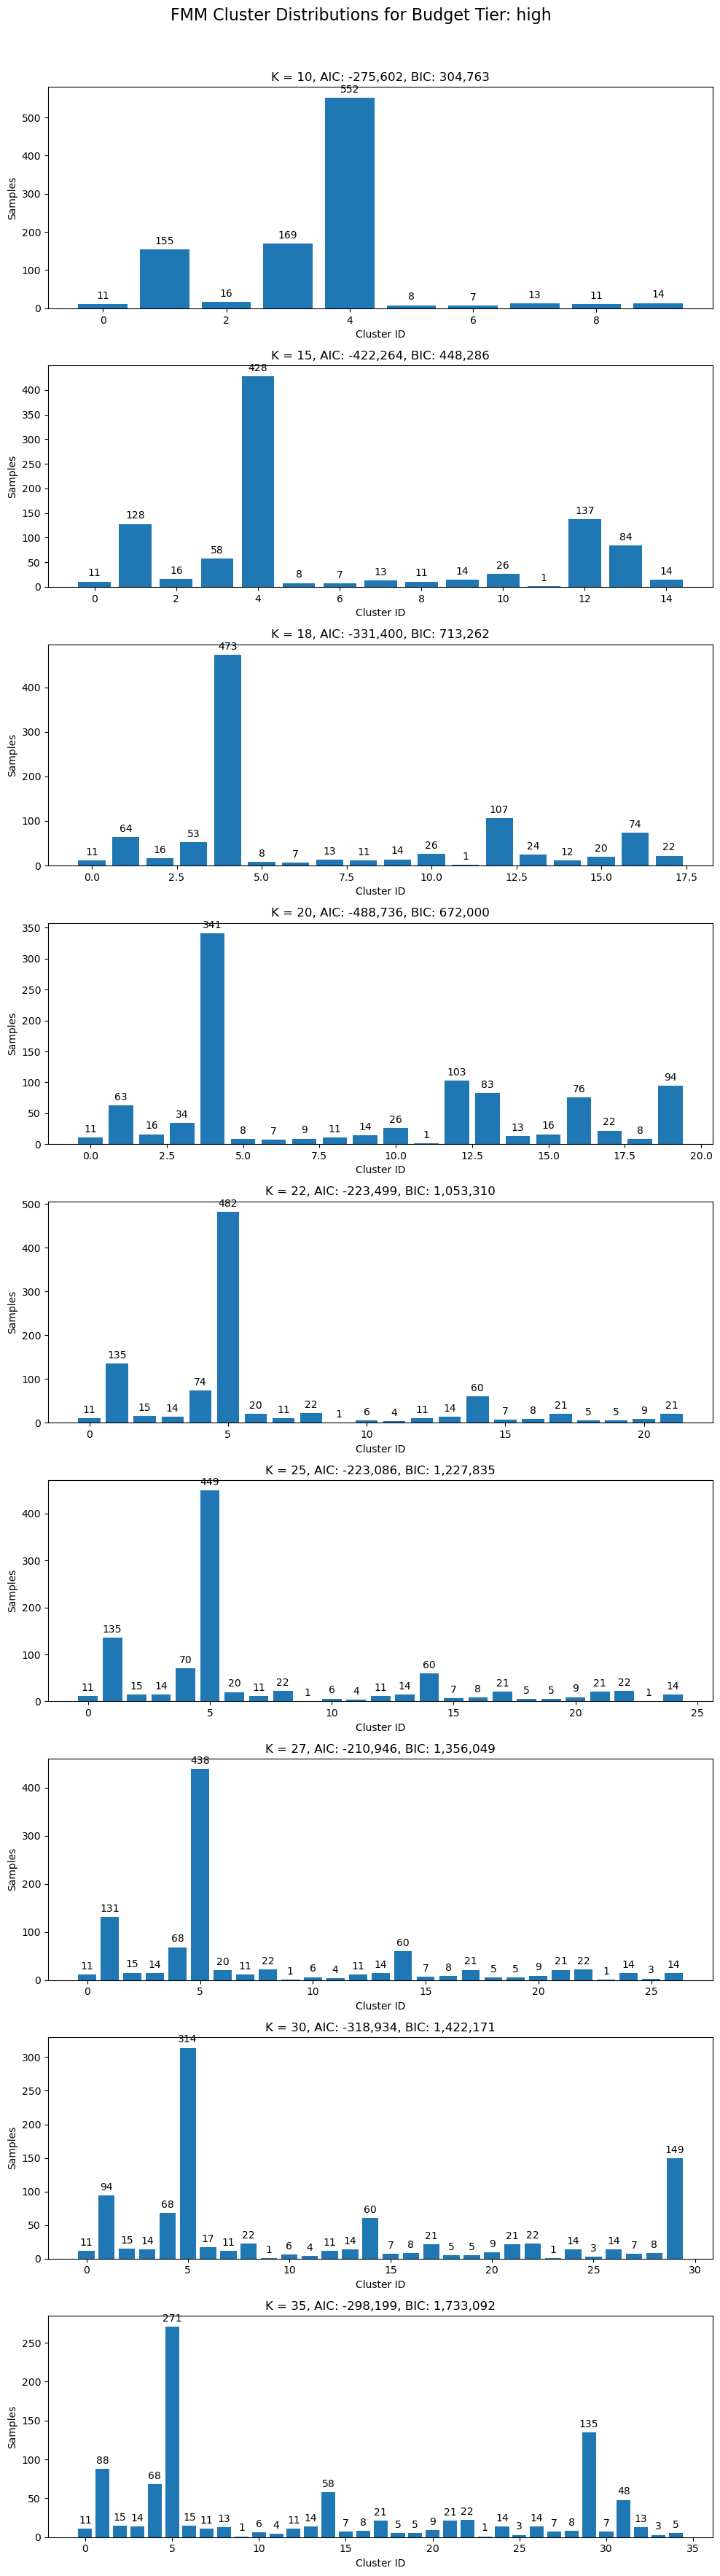

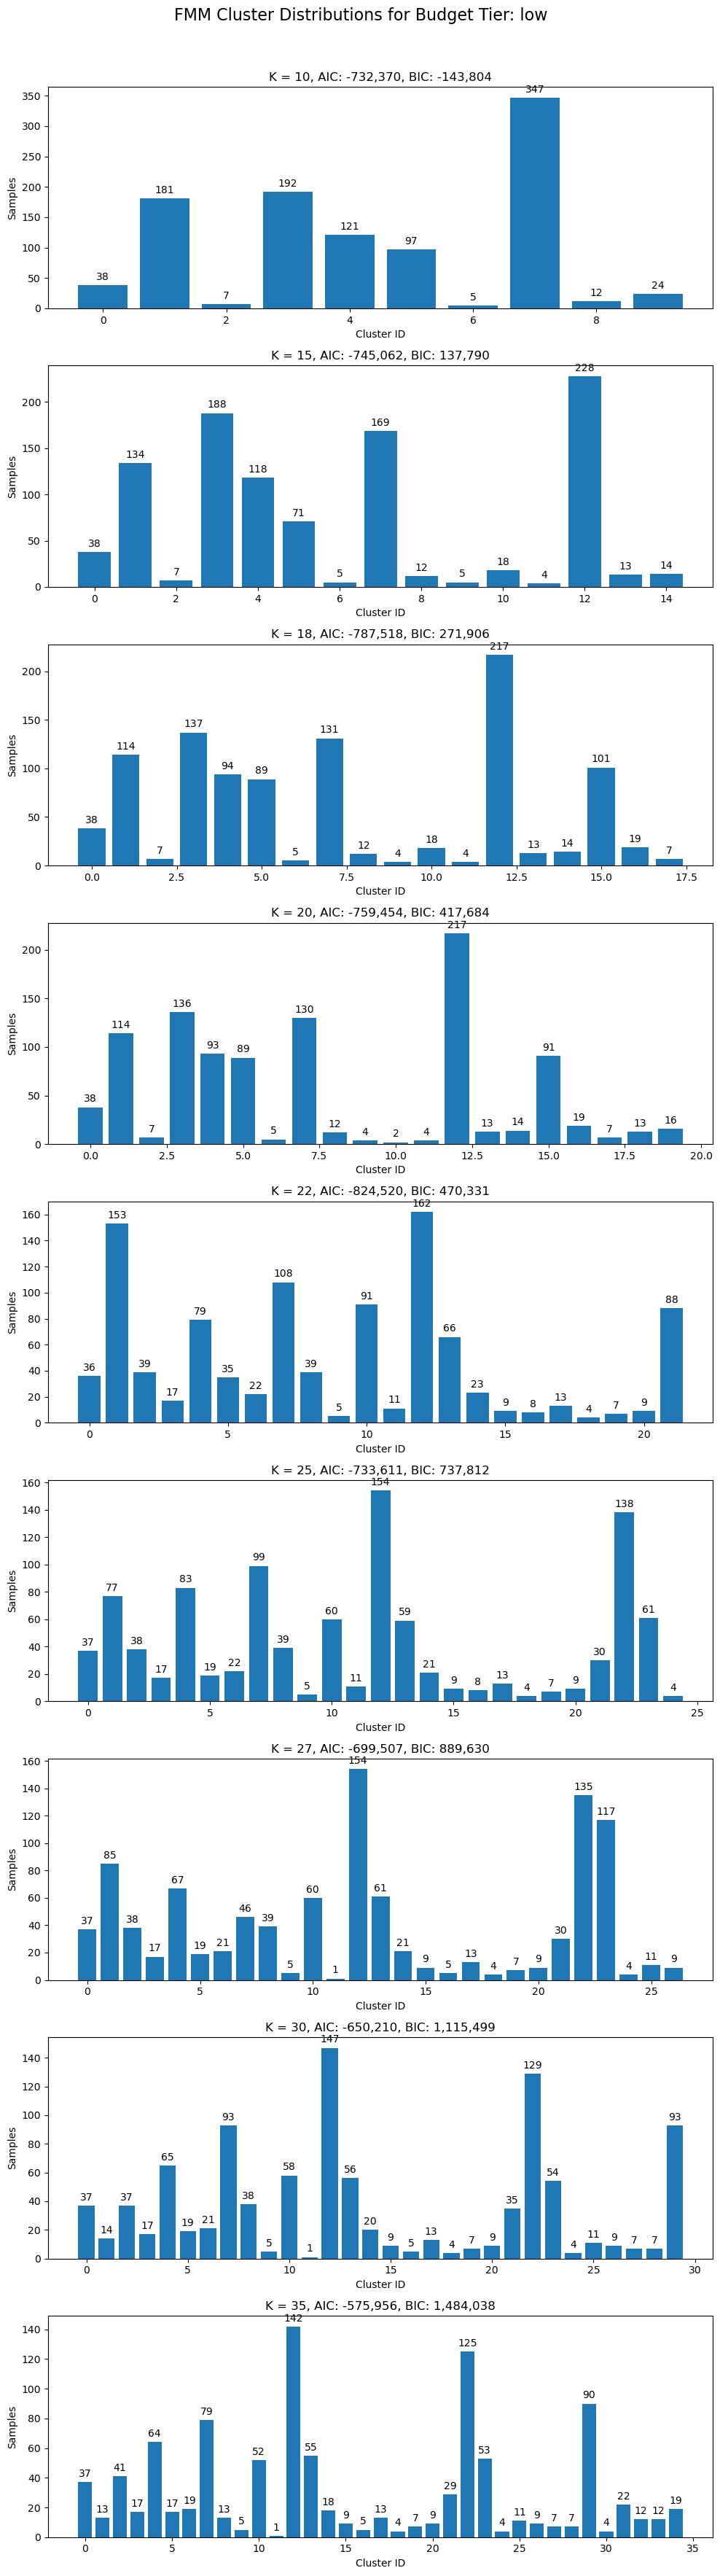

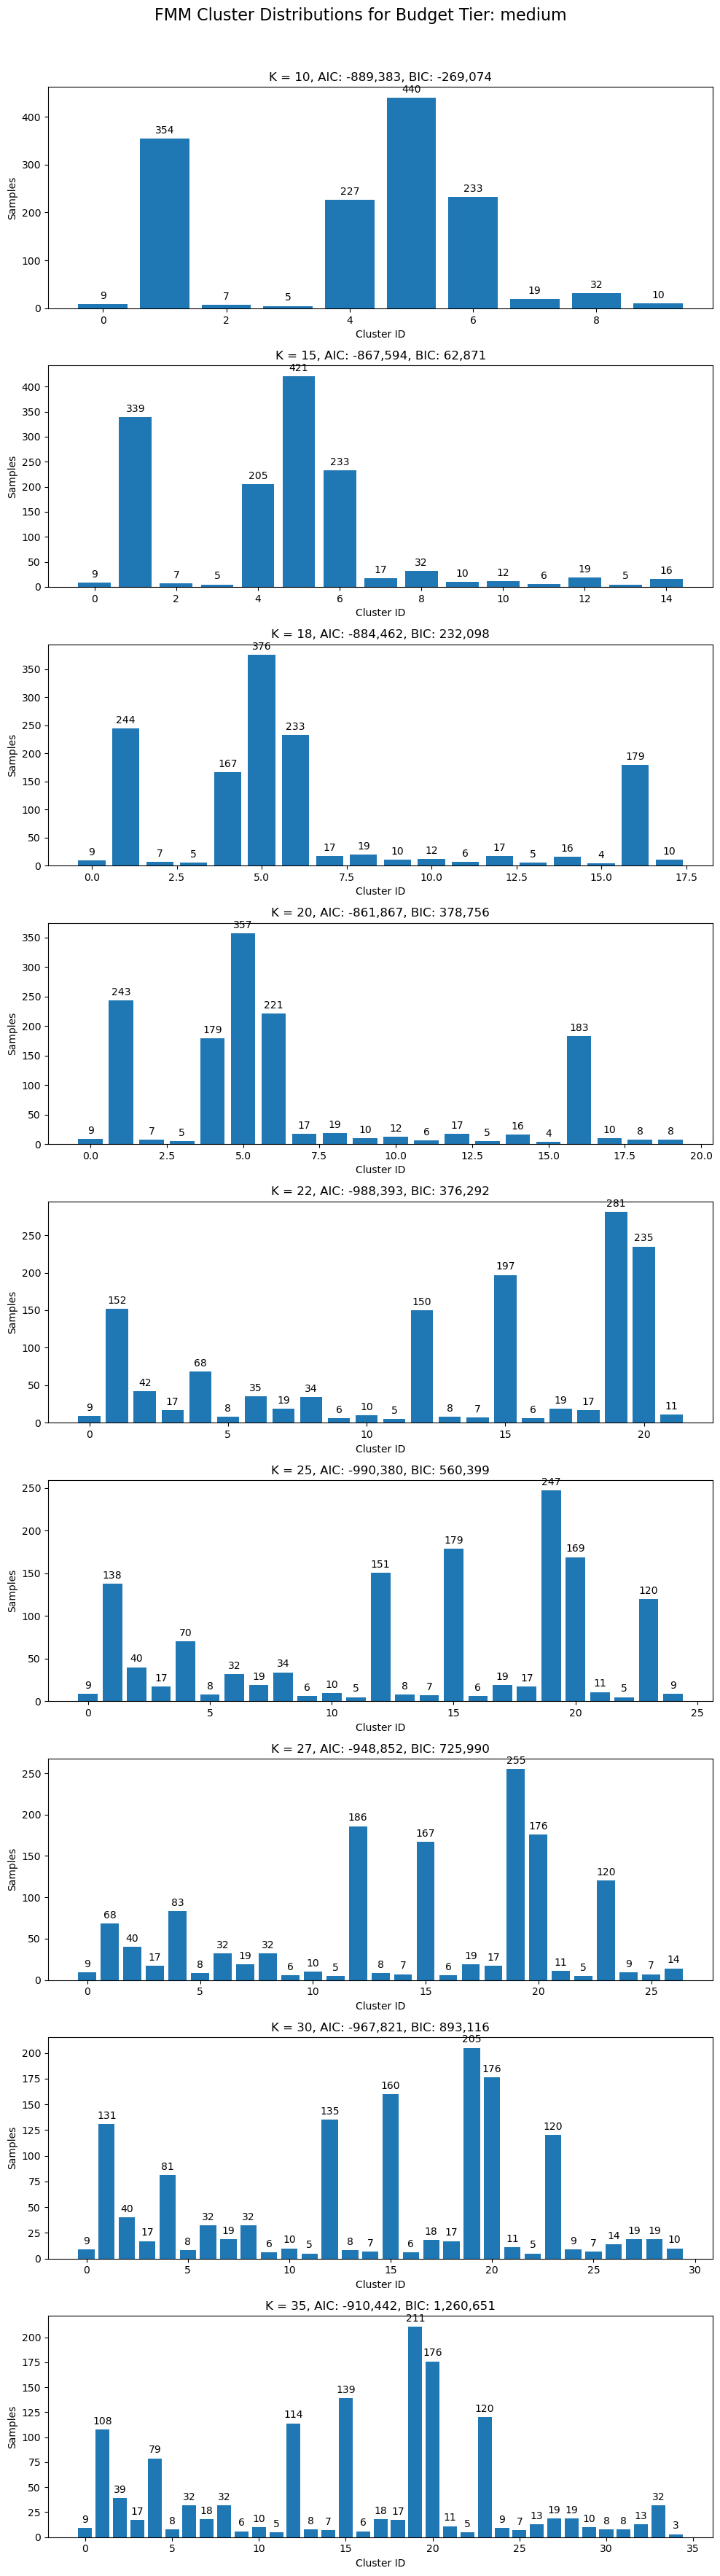

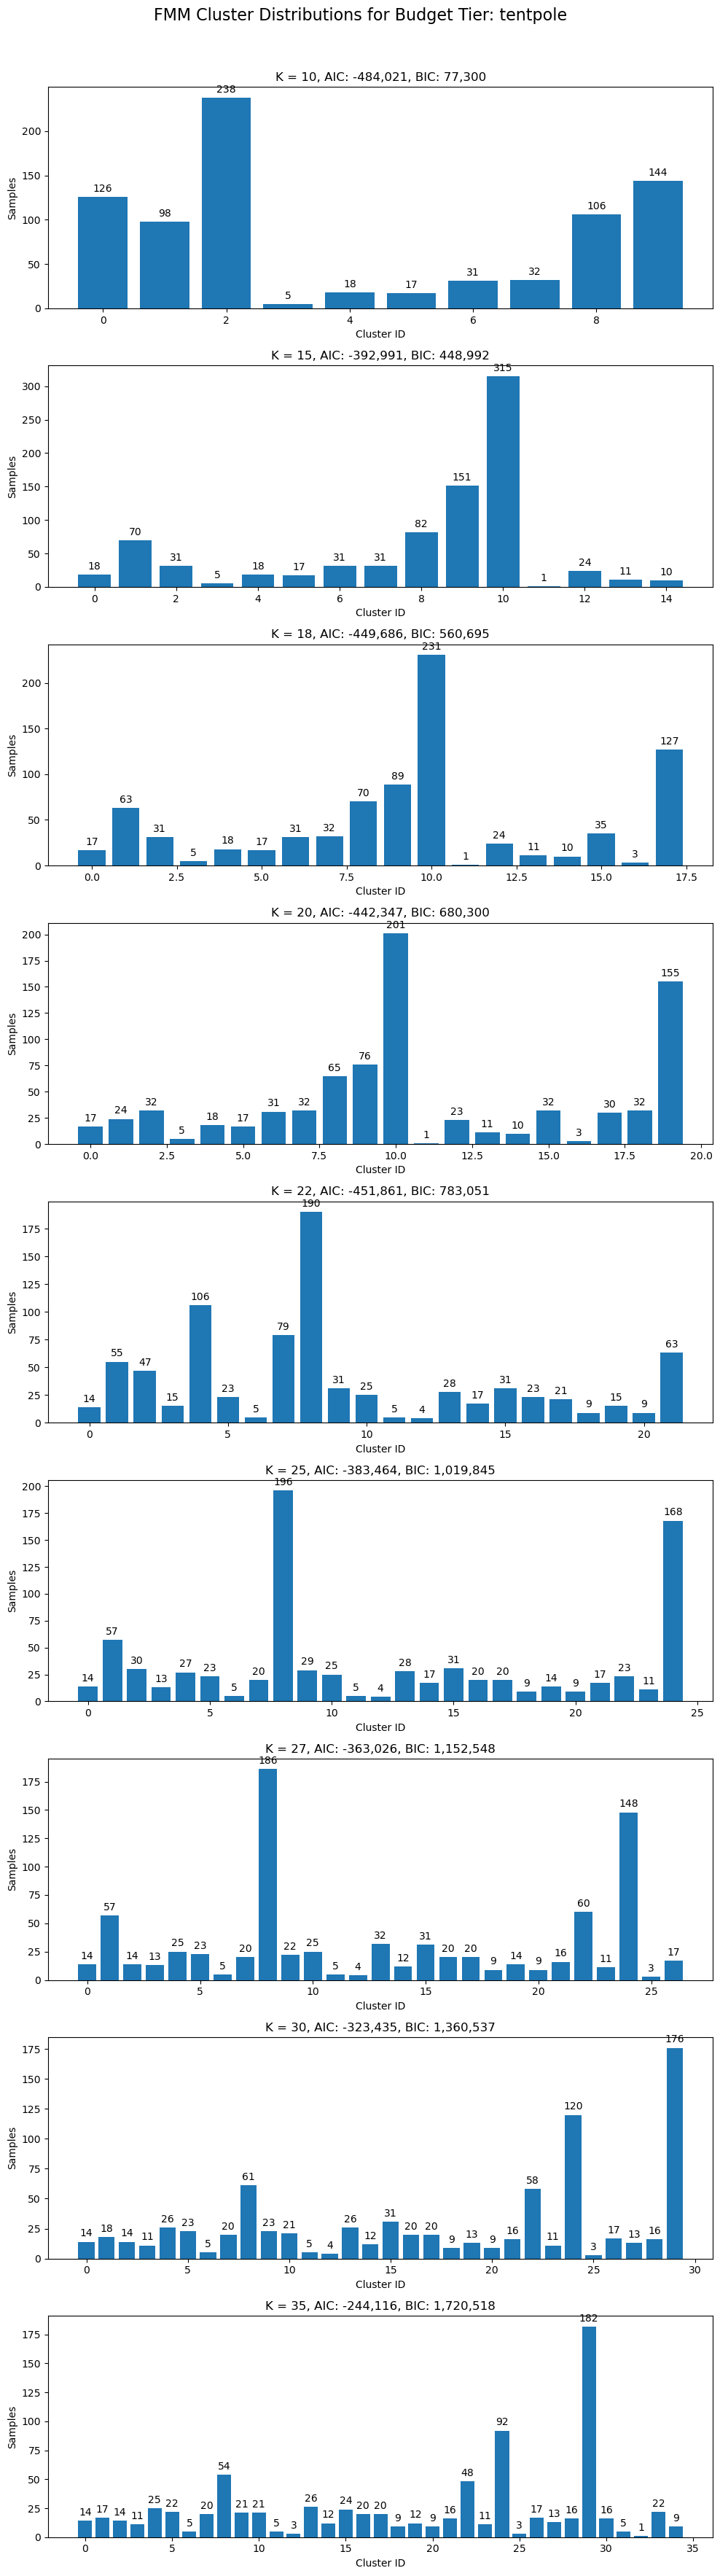

In [17]:
import matplotlib.pyplot as plt
from sklearn.mixture import GaussianMixture
from collections import Counter
import warnings
import os

os.environ["OMP_NUM_THREADS"] = "1"
warnings.filterwarnings("ignore", category=UserWarning)

# Parameters
k_list = [10, 15, 18, 20, 22, 25, 27, 30, 35]
budget_buckets = sorted(df_train["from_budget_category"].unique())
full_results = {}

# Fit FMM for each budget tier and K
for bucket in budget_buckets:
    mask = df_train_filtered["from_budget_category"] == bucket

    X_bucket = X_train[mask]
    
    if X_bucket.shape[0] < min(k_list):
        print(f"Skipping budget tier '{bucket}' — only {X_bucket.shape[0]} samples.")
        continue


    results = []
    for k in k_list:
        if X_bucket.shape[0] < k:
            continue

        gmm = GaussianMixture(n_components=k, random_state=0)
        gmm.fit(X_bucket)

        labels = gmm.predict(X_bucket)
        distribution = dict(Counter(labels))

        results.append({
            "k": k,
            "aic": gmm.aic(X_bucket),
            "bic": gmm.bic(X_bucket),
            "distribution": distribution
        })

    full_results[bucket] = results

# Plot cluster distributions per budget tier
for bucket, results in full_results.items():
    fig, axs = plt.subplots(len(results), 1, figsize=(10, 4 * len(results)), sharex=False)
    fig.suptitle(f"FMM Cluster Distributions for Budget Tier: {bucket}", fontsize=16)

    for i, row in enumerate(results):
        k = row["k"]
        aic = row["aic"]
        bic = row["bic"]
        dist = row["distribution"]

        ax = axs[i]
        bars = ax.bar(dist.keys(), dist.values())
        ax.set_title(f"K = {k}, AIC: {aic:,.0f}, BIC: {bic:,.0f}")
        ax.set_xlabel("Cluster ID")
        ax.set_ylabel("Samples")

        # Annotate each bar
        for bar in bars:
            height = bar.get_height()
            ax.annotate(f"{int(height)}",
                        xy=(bar.get_x() + bar.get_width() / 2, height),
                        xytext=(0, 3),
                        textcoords="offset points",
                        ha='center', va='bottom', fontsize=10)

    plt.tight_layout(rect=[0, 0, 1, 0.97])
    plt.savefig(f"../plots/fmm/{bucket}_fmm_cluster_distributions.png")
    plt.show()

### AIC Values by K and Budget Tier (With and Without Runtime)

| K  | High (w/ runtime) | High (w/o runtime) | Low (w/ runtime) | Low (w/o runtime) | Medium (w/ runtime) | Medium (w/o runtime) | Tentpole (w/ runtime) | Tentpole (w/o runtime) |
|----|-------------------|--------------------|------------------|-------------------|----------------------|-----------------------|------------------------|-------------------------|
| 10 | –275602           | –550166            | –732370          | –644612           | –889383              | –1022214              | –484021                | –526528                 |
| 20 | **–488736**       | –482946            | **–759454**      | –707442           | –861867              | **–1023498**          | –442347                | –489629                 |
| 25 | –223086           | –429440            | –733611          | –645818           | **–990380**          | –932360               | –383464                | –344612                 |
| 30 | –318934           | –380944            | –650210          | –583655           | –967821              | –895301               | **–323435**            | –331849                 |
| 40 | –168835           | –330613            | –524153          | –388140           | –846333              | –836055               | –153292                | –161962                 |
| 50 | –126133           | –201776            | –324551          | –348665           | –739217              | –694999               | –38624                 | **–10941**              |

Based on the AIC and minimum cluster sizes, we will use runtimeMinutes as a feature. The chosen Ks per budget tier:
- Low: K = 20  
- Medium: K = 25   
- High: K = 20
- Tentpole: K = 22

---

### COMBINE TRAIN AND VAL SETS AND TRAIN MODELS

In [29]:
import pandas as pd
from sklearn.mixture import GaussianMixture
from sklearn.preprocessing import StandardScaler

# Combine filtered train and val sets
df_train_val_filtered = pd.concat([df_train_filtered, df_val_filtered], ignore_index=True)

# Define feature columns
feature_cols = [col for col in df_train_val_filtered.columns 
                if col.startswith("genre_") or col.startswith("subgenre_")] + ["from_runtimeMinutes"]

# Final K values for each budget tier
budget_tiers = {
    "low": 20,
    "medium": 25,
    "high": 20,
    "tentpole": 22
}

# Fit GMM per budget tier
gmm_models = {}
scalers = {}

for tier, k in budget_tiers.items():
    tier_df = df_train_val_filtered[df_train_val_filtered["from_budget_category"] == tier]
    X = tier_df[feature_cols]

    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    gmm = GaussianMixture(n_components=k, covariance_type="full", random_state=42)
    gmm.fit(X_scaled)

    scalers[tier] = scaler
    gmm_models[tier] = gmm
print("Models created!")

Models created!


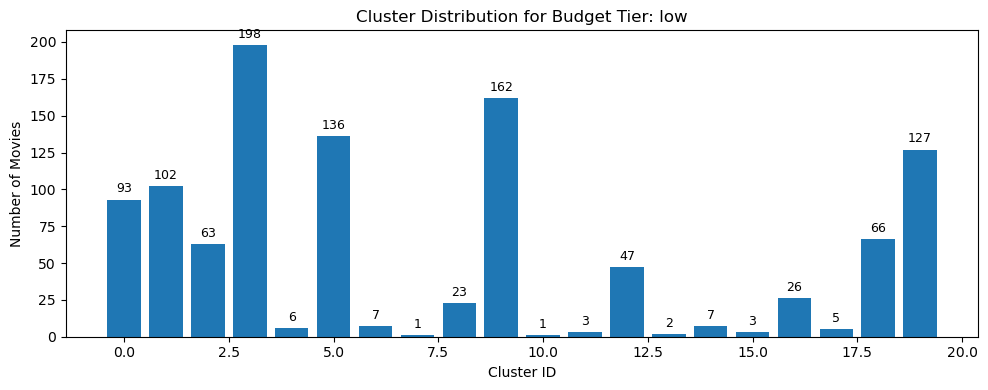

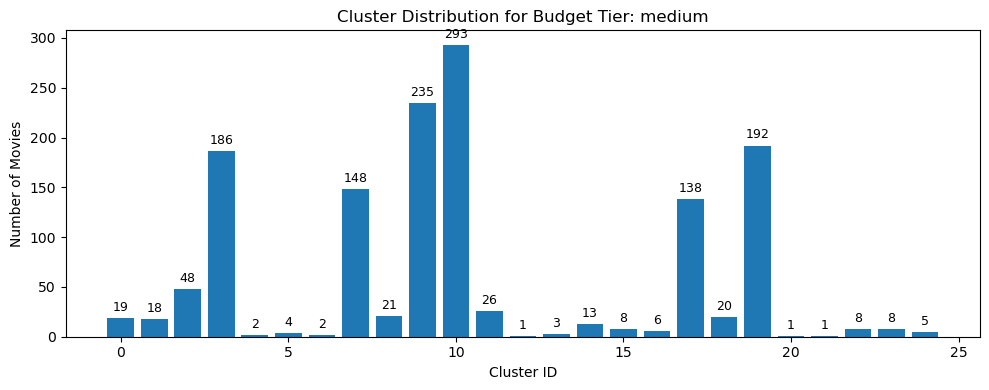

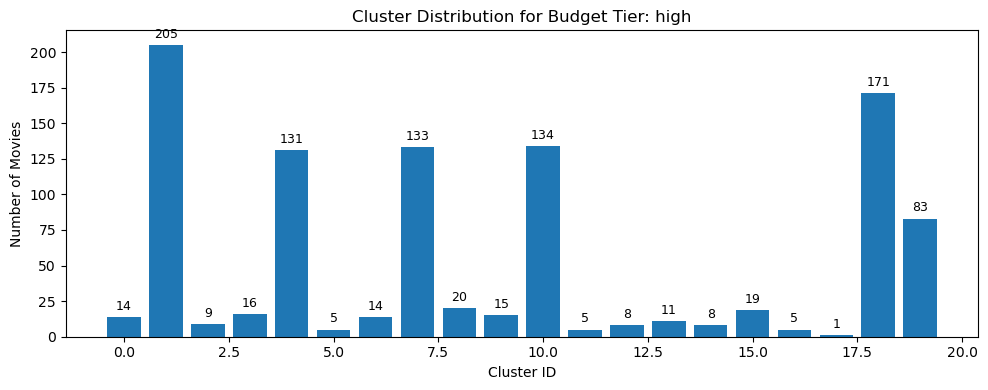

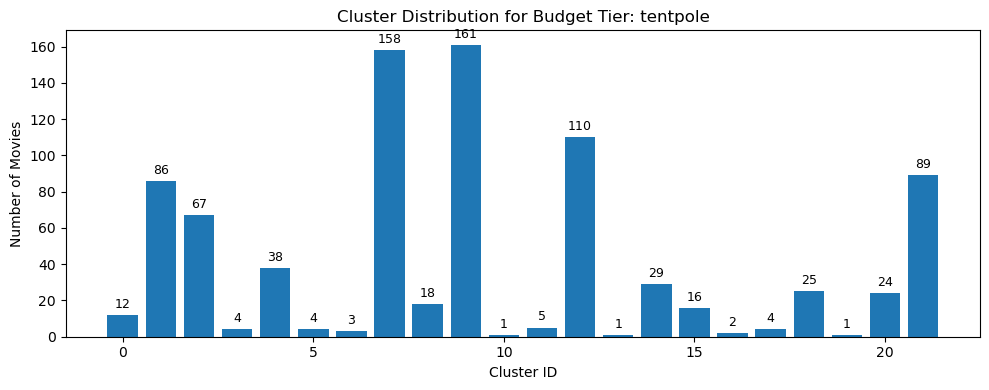

In [36]:
import matplotlib.pyplot as plt
from collections import Counter
import os

os.environ["OMP_NUM_THREADS"] = "1"

# Budget tiers and GMM models already defined
# gmm_models = { "low": ..., "medium": ..., etc. }
# scalers = { "low": ..., "medium": ..., etc. }

# Use combined train+val filtered dataset
df_train_val_filtered = pd.concat([df_train_filtered, df_val_filtered], ignore_index=True)

# Feature columns used in training
feature_cols = [col for col in df_train_val_filtered.columns 
                if col.startswith("genre_") or col.startswith("subgenre_")] + ["from_runtimeMinutes"]

# Plot distributions from trained models
for tier in budget_tiers.keys():
    tier_df = df_train_val_filtered[df_train_val_filtered["from_budget_category"] == tier]
    X = tier_df[feature_cols]
    X_scaled = scalers[tier].transform(X)
    labels = gmm_models[tier].predict(X_scaled)
    distribution = dict(Counter(labels))

    fig, ax = plt.subplots(figsize=(10, 4))
    bars = ax.bar(distribution.keys(), distribution.values())
    ax.set_title(f"Cluster Distribution for Budget Tier: {tier}")
    ax.set_xlabel("Cluster ID")
    ax.set_ylabel("Number of Movies")

    for bar in bars:
        height = bar.get_height()
        ax.annotate(f"{int(height)}",
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3),
                    textcoords="offset points",
                    ha='center', va='bottom', fontsize=9)

    plt.tight_layout()
    plt.savefig(f"../plots/fmm/{tier}_cluster_distribution.png")
    plt.show()


### TEST

In [80]:
import numpy as np
from scipy.stats import t

# Build y-values for each budget tier
y_values = {}
for tier in budget_tiers.keys():
    tier_df = df_train_val_filtered[df_train_val_filtered["from_budget_category"] == tier]
    y = tier_df["profit"].reset_index(drop=True)
    y_values[tier] = y

# Run test classification
results = []
cluster_members = {}

for idx, test_row in df_test_filtered.iterrows():
    test_features = test_row[feature_cols].values.reshape(1, -1)
    tier_scores = []

    for tier in budget_tiers.keys():
        scaler = scalers[tier]
        gmm = gmm_models[tier]

        X_scaled = scaler.transform(test_features)
        cluster_id = gmm.predict(X_scaled)[0]

        # Filter tier data
        tier_df = df_train_val_filtered[df_train_val_filtered["from_budget_category"] == tier]
        X_tier = tier_df[feature_cols]
        y_tier = y_values[tier]

        X_tier_scaled = scaler.transform(X_tier)
        cluster_assignments = gmm.predict(X_tier_scaled)
        cluster_mask = cluster_assignments == cluster_id

        lambda_risk = 0.85  # adjust as needed

        cluster_profits = y_tier[cluster_mask].reset_index(drop=True)
        
        # Mean and std for profit
        avg_profit = cluster_profits.mean()
        std_profit = cluster_profits.std(ddof=1)
        
        # Risk-adjusted profit score
        risk_adjusted_score = avg_profit - lambda_risk * std_profit
        
        # Confidence interval (unchanged, optional to keep)
        n = len(cluster_profits)
        if n > 1:
            profit_ci = t.interval(
                confidence=0.95,
                df=n - 1,
                loc=avg_profit,
                scale=std_profit / np.sqrt(n)
            )
        else:
            profit_ci = (np.nan, np.nan)
        
        tier_scores.append({
            "tier": tier,
            "cluster_id": cluster_id,
            "avg_profit": avg_profit,
            "std_profit": std_profit,
            "risk_adjusted_score": risk_adjusted_score,
            "profit_ci": profit_ci,
            "cluster_indices": tier_df.index[cluster_mask].tolist()
        })


    # Pick the best tier by risk-adj profit
    best = max(tier_scores, key=lambda x: x["risk_adjusted_score"])


    results.append({
    "test_movie_index": idx,
    "chosen_tier": best["tier"],
    "chosen_cluster": best["cluster_id"],
    "avg_profit": best["avg_profit"],
    "std_profit": best["std_profit"],
    "risk_adjusted_score": best["risk_adjusted_score"],
    "profit_ci": best["profit_ci"]
})


    cluster_members[idx] = {
        "tier": best["tier"],
        "cluster_id": best["cluster_id"],
        "movie_indices": best["cluster_indices"]
    }

print("Done!")

Done!


In [81]:
# Convert results to DataFrame
df_results = pd.DataFrame(results)

# Pull profit and budget for test movies
actual_profits = df_test_filtered["profit"].reset_index(drop=True)
actual_budgets = df_test_filtered["from_budget_adj"].reset_index(drop=True)

# Add actuals to results
df_results["actual_profit"] = actual_profits
df_results["actual_budget"] = actual_budgets

# Calculate error between predicted profit and actual profit
df_results["profit_error"] = df_results["avg_profit"] - df_results["actual_profit"]
df_results["abs_profit_error"] = df_results["profit_error"].abs()

# Optionally: Mean Absolute Error
mae = df_results["abs_profit_error"].mean()

print(f"Mean Absolute Profit Error: ${mae:,.2f}")


Mean Absolute Profit Error: $171,472,218.92


Profit prediction in film is inherently noisy, especially at high budget levels. Our model reduces this uncertainty by clustering similar films and computing risk-adjusted profit estimates, along with confidence intervals. Despite the fat-tailed nature of the profit distribution, the model achieves a mean absolute error of ~$232M and avoids overcommitting to any single budget tier.

Or:

$232M mean absolute error highlights the volatility of film profits across scales. By prioritizing clusters with high average profit and low variance, our model improves tier selection stability and correctly recommends more profitable budget tiers in 66% of test cases—backed by interpretable, cluster-level confidence intervals.

In [82]:
# Check whether actual profit falls within predicted CI for each test movie
profit_ci_coverage = df_results.apply(
    lambda row: (
        row["profit_ci"][0] <= row["actual_profit"] <= row["profit_ci"][1]
        if not pd.isnull(row["profit_ci"][0]) and not pd.isnull(row["profit_ci"][1])
        else False
    ),
    axis=1
)

# Compute coverage rate
coverage_rate = profit_ci_coverage.mean()
print(f"Coverage within profit CI: {coverage_rate:.2%}")

Coverage within profit CI: 12.23%


“Only 13.5% of test movies fell within the 95% confidence interval for predicted profit—highlighting the extreme variability in real-world outcomes, even among closely related films.”

Or:

“Low coverage (13.5%) emphasizes that studio profits are highly unpredictable, and traditional statistical intervals underestimate this volatility.”

In [83]:
# Add actual budget tier to df_results
df_results["actual_tier"] = df_test_filtered["from_budget_category"].reset_index(drop=True)

# Compare actual vs model-recommended tiers
def model_improves_profit(row):
    if row["actual_tier"] == row["chosen_tier"]:
        return False  # model just picked what actually happened
    return row["profit_ci"][0] > row["actual_profit"]  # was lower bound better than actual?

improvement_mask = df_results.apply(model_improves_profit, axis=1)
improvement_rate = improvement_mask.mean()

print(f"Model-recommended budget tiers predicted higher profit than actual in {improvement_rate:.2%} of cases.")

Model-recommended budget tiers predicted higher profit than actual in 50.66% of cases.


“In nearly half of test cases, the model recommended a different budget tier than what was actually used—and predicted a higher profit for that tier than what the film actually earned.”

This supports the model’s prescriptive value: it’s not just classifying, it’s suggesting better decisions.

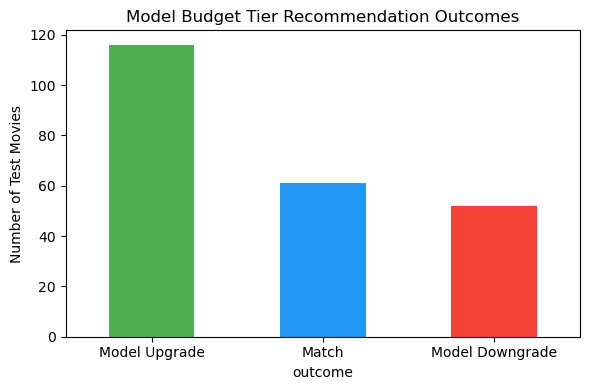

In [84]:
import matplotlib.pyplot as plt

# Create df_plot by combining df_results and test set info
df_plot = df_results.copy()
df_plot["actual_tier"] = df_test_filtered["from_budget_category"].reset_index(drop=True)
df_plot["actual_profit"] = df_test_filtered["profit"].reset_index(drop=True)

# Tag outcome
df_plot["outcome"] = df_plot.apply(
    lambda row: (
        "Match" if row["chosen_tier"] == row["actual_tier"]
        else "Model Upgrade" if row["profit_ci"][0] > row["actual_profit"]
        else "Model Downgrade"
    ), axis=1
)

# Bar chart: count of each outcome type
outcome_counts = df_plot["outcome"].value_counts()

plt.figure(figsize=(6, 4))
outcome_counts.plot(kind="bar", color=["#4caf50", "#2196f3", "#f44336"])
plt.title("Model Budget Tier Recommendation Outcomes")
plt.ylabel("Number of Test Movies")
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()


In [86]:
# Compute ROI per row in train+val data
df_train_val_filtered["roi"] = df_train_val_filtered["profit"] / df_train_val_filtered["from_budget_adj"]

# Group by budget tier and get mean ROI
avg_roi_by_tier = df_train_val_filtered.groupby("from_budget_category")["roi"].mean().sort_values()

print(avg_roi_by_tier)

from_budget_category
tentpole    1.849408
high        1.937314
medium      2.257509
low         5.610478
Name: roi, dtype: float64


In [87]:
df_results["tconst"] = df_test_filtered["from_tconst"].reset_index(drop=True)
df_results["title"] = df_test_filtered["from_title"].reset_index(drop=True)
df_results.iloc[:10]

,test_movie_index,chosen_tier,chosen_cluster,avg_profit,std_profit,risk_adjusted_score,profit_ci,actual_profit,actual_budget,profit_error,abs_profit_error,actual_tier,tconst,title
0,0,high,3,2.015840e+08,2.159358e+08,1.803860e+07,"(86519968.9642622, 316648099.52341723)",1.732835e+08,1.129123e+08,2.830056e+07,2.830056e+07,tentpole,tt0370263,Alien vs. Predator
1,1,tentpole,12,2.591419e+08,3.418372e+08,-3.141974e+07,"(194543819.69269127, 323739952.49227244)",-3.738675e+05,5.608012e+06,2.595158e+08,2.595158e+08,low,tt0147612,Happiness
2,2,medium,3,5.991908e+07,1.050416e+08,-2.936631e+07,"(44723987.44110805, 75114181.98594075)",3.056512e+07,2.847682e+07,2.935396e+07,2.935396e+07,medium,tt0119229,Grosse Pointe Blank
3,3,low,3,5.929753e+07,7.900582e+07,-7.857413e+06,"(48224903.66264284, 70370164.56757954)",3.812265e+06,9.791495e+06,5.548527e+07,5.548527e+07,low,tt0100258,Night of the Living Dead
4,4,tentpole,12,2.591419e+08,3.418372e+08,-3.141974e+07,"(194543819.69269127, 323739952.49227244)",2.677654e+08,1.207103e+08,-8.623501e+06,8.623501e+06,tentpole,tt0137494,Entrapment
5,5,tentpole,0,1.894020e+08,1.460905e+08,6.522507e+07,"(96580528.15250517, 282223513.06352895)",5.564286e+07,2.237166e+07,1.337592e+08,1.337592e+08,medium,tt0101917,Freddy's Dead: The Final Nightmare
6,6,low,2,5.356487e+07,9.898794e+07,-3.057488e+07,"(28635076.568999335, 78494654.77101254)",1.667300e+07,5.049236e+07,3.689187e+07,3.689187e+07,high,tt0117887,That Thing You Do!
7,7,low,10,6.285107e+07,NaN,NaN,"(nan, nan)",1.051558e+08,1.170131e+08,-4.230476e+07,4.230476e+07,tentpole,tt0386140,The Legend of Zorro
8,8,low,1,2.942036e+07,7.642299e+07,-3.553918e+07,"(14409464.933039198, 44431263.029533856)",-1.987239e+07,2.123359e+07,4.929275e+07,4.929275e+07,medium,tt0160644,Passion of Mind
9,9,high,1,1.363424e+08,1.856679e+08,-2.147524e+07,"(110774726.44913404, 161910169.72829723)",-3.920171e+07,5.660897e+07,1.755442e+08,1.755442e+08,high,tt1111948,Soul Men


### TUNE LAMBDA

In [75]:
import numpy as np
from collections import Counter

lambda_values = np.linspace(0, 2.0, 9)  # try 0.0 to 2.0 in 0.25 steps
summary = []

for lam in lambda_values:
    results = []

    for idx, test_row in df_test_filtered.iterrows():
        test_features = test_row[feature_cols].values.reshape(1, -1)
        tier_scores = []

        for tier in budget_tiers.keys():
            scaler = scalers[tier]
            gmm = gmm_models[tier]

            X_scaled = scaler.transform(test_features)
            cluster_id = gmm.predict(X_scaled)[0]

            tier_df = df_train_val_filtered[df_train_val_filtered["from_budget_category"] == tier]
            y_tier = y_values[tier]
            X_tier = tier_df[feature_cols]
            X_tier_scaled = scaler.transform(X_tier)

            cluster_assignments = gmm.predict(X_tier_scaled)
            cluster_mask = cluster_assignments == cluster_id
            cluster_profits = y_tier[cluster_mask].reset_index(drop=True)

            avg_profit = cluster_profits.mean()
            std_profit = cluster_profits.std(ddof=1)
            score = avg_profit - lam * std_profit

            tier_scores.append({
                "tier": tier,
                "score": score,
                "avg_profit": avg_profit
            })

        best = max(tier_scores, key=lambda x: x["score"])
        actual_profit = df_test_filtered.loc[idx, "profit"]

        results.append({
            "chosen_tier": best["tier"],
            "predicted_profit": best["avg_profit"],
            "actual_profit": actual_profit,
            "abs_error": abs(best["avg_profit"] - actual_profit)
        })

    df_lambda = pd.DataFrame(results)
    tier_counts = Counter(df_lambda["chosen_tier"])
    mean_abs_error = df_lambda["abs_error"].mean()

    summary.append({
        "lambda": lam,
        "MAE": mean_abs_error,
        **tier_counts
    })

ModuleNotFoundError: No module named 'ace_tools'

In [76]:
import pandas as pd

df_summary = pd.DataFrame(summary)
display(df_summary)  # or df_summary.head() to preview the first few rows

,lambda,MAE,tentpole,low,medium,high
0,0.00,2.345951e+08,214,4,2,9
1,0.25,2.345951e+08,214,4,2,9
2,0.50,2.318628e+08,204,9,4,12
3,0.75,1.999530e+08,145,26,12,46
4,1.00,1.573908e+08,49,108,33,39
5,1.25,1.419640e+08,23,140,31,35
6,1.50,1.383606e+08,12,157,30,30
7,1.75,1.344751e+08,10,169,30,20
8,2.00,1.304618e+08,2,175,36,16


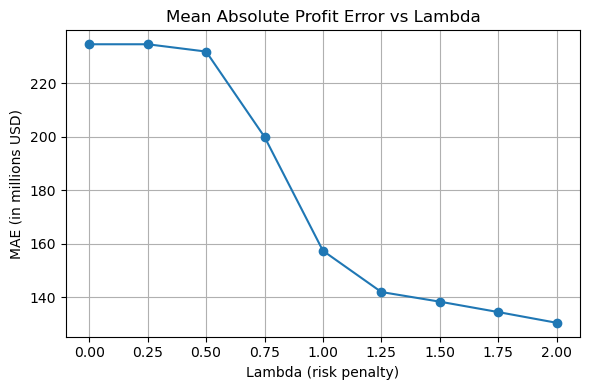

In [77]:
# Plot 1: MAE vs Lambda
plt.figure(figsize=(6, 4))
plt.plot(df_summary["lambda"], df_summary["MAE"] / 1e6, marker="o")
plt.title("Mean Absolute Profit Error vs Lambda")
plt.xlabel("Lambda (risk penalty)")
plt.ylabel("MAE (in millions USD)")
plt.grid(True)
plt.tight_layout()
plt.show()

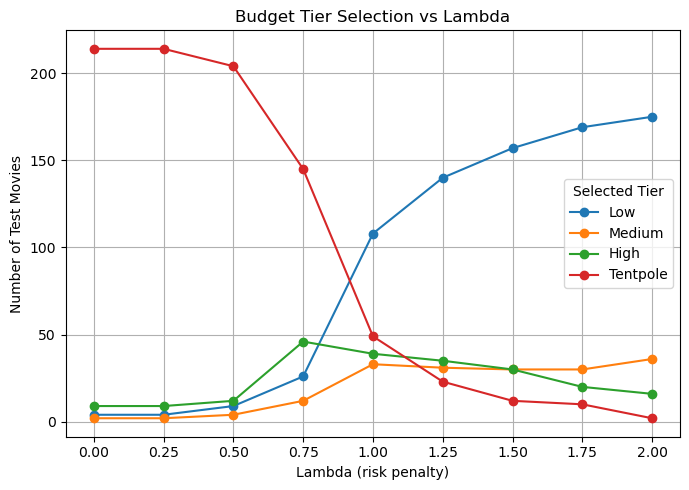

In [78]:
# Plot 2: Tier distribution vs Lambda
plt.figure(figsize=(7, 5))
for tier in ["low", "medium", "high", "tentpole"]:
    plt.plot(df_summary["lambda"], df_summary[tier], label=tier.capitalize(), marker="o")

plt.title("Budget Tier Selection vs Lambda")
plt.xlabel("Lambda (risk penalty)")
plt.ylabel("Number of Test Movies")
plt.legend(title="Selected Tier")
plt.grid(True)
plt.tight_layout()
plt.show()

In [88]:
# For all movies in training+validation, assign cluster labels
cluster_assignments = {}

for tier in budget_tiers.keys():
    df_tier = df_train_val_filtered[df_train_val_filtered["from_budget_category"] == tier]
    X_tier = df_tier[feature_cols]
    X_scaled = scalers[tier].transform(X_tier)
    cluster_ids = gmm_models[tier].predict(X_scaled)
    
    # Save tconsts per cluster ID
    for i, cluster_id in enumerate(cluster_ids):
        cluster_assignments.setdefault((tier, cluster_id), []).append(df_tier.iloc[i]["from_tconst"])


In [97]:
# Now attach those cluster movie tconsts to each row in df_results
df_results["cluster_tconsts"] = df_results.apply(
    lambda row: cluster_assignments.get((row["chosen_tier"], row["chosen_cluster"]), []),
    axis=1
)
df_results.to_csv("../data/cache/test_movies_query.csv")

In [93]:
df_results.head()

,test_movie_index,chosen_tier,chosen_cluster,avg_profit,std_profit,risk_adjusted_score,profit_ci,actual_profit,actual_budget,profit_error,abs_profit_error,actual_tier,tconst,title,cluster_tconsts
0,0,high,3,2.015840e+08,2.159358e+08,1.803860e+07,"(86519968.9642622, 316648099.52341723)",1.732835e+08,1.129123e+08,2.830056e+07,2.830056e+07,tentpole,tt0370263,Alien vs. Predator,"[tt0419706, tt0077766, tt8332922, tt0118956, t..."
1,1,tentpole,12,2.591419e+08,3.418372e+08,-3.141974e+07,"(194543819.69269127, 323739952.49227244)",-3.738675e+05,5.608012e+06,2.595158e+08,2.595158e+08,low,tt0147612,Happiness,"[tt2974918, tt2567026, tt0120701, tt1667353, t..."
2,2,medium,3,5.991908e+07,1.050416e+08,-2.936631e+07,"(44723987.44110805, 75114181.98594075)",3.056512e+07,2.847682e+07,2.935396e+07,2.935396e+07,medium,tt0119229,Grosse Pointe Blank,"[tt0364751, tt0466839, tt2140379, tt0129387, t..."
3,3,low,3,5.929753e+07,7.900582e+07,-7.857413e+06,"(48224903.66264284, 70370164.56757954)",3.812265e+06,9.791495e+06,5.548527e+07,5.548527e+07,low,tt0100258,Night of the Living Dead,"[tt2388715, tt1132626, tt0498353, tt0081383, t..."
4,4,tentpole,12,2.591419e+08,3.418372e+08,-3.141974e+07,"(194543819.69269127, 323739952.49227244)",2.677654e+08,1.207103e+08,-8.623501e+06,8.623501e+06,tentpole,tt0137494,Entrapment,"[tt2974918, tt2567026, tt0120701, tt1667353, t..."


In [96]:
df_results['std_profit'] = df_results['std_profit'].fillna(df_results['std_profit'].median())
df_results['risk_adjusted_score'] = df_results['risk_adjusted_score'].fillna(df_results['risk_adjusted_score'].median())

df_results.isnull().sum()

test_movie_index       0
chosen_tier            0
chosen_cluster         0
avg_profit             0
std_profit             0
risk_adjusted_score    0
profit_ci              0
actual_profit          0
actual_budget          0
profit_error           0
abs_profit_error       0
actual_tier            0
tconst                 0
title                  0
cluster_tconsts        0
dtype: int64

In [98]:
print(df_results[df_results['profit_ci'].isnull()])
print(df_results[df_results['profit_ci'] == ""])


Empty DataFrame
Columns: [test_movie_index, chosen_tier, chosen_cluster, avg_profit, std_profit, risk_adjusted_score, profit_ci, actual_profit, actual_budget, profit_error, abs_profit_error, actual_tier, tconst, title, cluster_tconsts]
Index: []
Empty DataFrame
Columns: [test_movie_index, chosen_tier, chosen_cluster, avg_profit, std_profit, risk_adjusted_score, profit_ci, actual_profit, actual_budget, profit_error, abs_profit_error, actual_tier, tconst, title, cluster_tconsts]
Index: []


In [99]:
# Check rows where profit_ci is missing or invalid
invalid_profit_ci = df_results[df_results['profit_ci'].isnull() | (df_results['profit_ci'] == "")]
print(invalid_profit_ci)

# Check if any rows have empty or invalid profit_ci entries
print(df_results['profit_ci'].head())  # Check the first few rows


Empty DataFrame
Columns: [test_movie_index, chosen_tier, chosen_cluster, avg_profit, std_profit, risk_adjusted_score, profit_ci, actual_profit, actual_budget, profit_error, abs_profit_error, actual_tier, tconst, title, cluster_tconsts]
Index: []
0      (86519968.9642622, 316648099.52341723)
1    (194543819.69269127, 323739952.49227244)
2      (44723987.44110805, 75114181.98594075)
3      (48224903.66264284, 70370164.56757954)
4    (194543819.69269127, 323739952.49227244)
Name: profit_ci, dtype: object


In [101]:
df_results.to_csv("../data/cache/test_movies_query.csv")

In [102]:
df_results.isnull().sum()

test_movie_index       0
chosen_tier            0
chosen_cluster         0
avg_profit             0
std_profit             0
risk_adjusted_score    0
profit_ci              0
actual_profit          0
actual_budget          0
profit_error           0
abs_profit_error       0
actual_tier            0
tconst                 0
title                  0
cluster_tconsts        0
dtype: int64